# (Stochastic) Windy Gridworld with King's Moves

This notebook contains an implementation of the Sarsa algorithm to solve the windy gridworld problem. Two configurations of the gridworld are implemented: one with stochastic winds and one without. Additionally, it is possible to restrict the amount of actions.

The state of this problem is simply the location of the agent on the grid, therefore it can be stored using an array. The whole task is undiscounted, i.e. $\gamma=1$. The stochastic flavour can simply be implemented in the `act` function and is opaque to the RL method.

In [1]:
using Plots
using Statistics
using Base.Iterators

In [2]:
gamma = 1.
epsilon = .1
alpha = .5
episodes = 170

170

In [3]:
mutable struct Gridworld
    wind::Array{Int32}
    rows::Int32
    agent::CartesianIndex{2}
    goal::CartesianIndex{2}
end

reset_state(g::Gridworld) = g.agent = CartesianIndex(4, 1)

"""
Performs an action on the gridworld and returns the recieved reward and a termination flag.

# Arguments
- `action`:
    - 1: left
    - 2: right
    - 3: up
    - 4: down
    - 5: left-up
    - 6: right-up
    - 7: left-down
    - 8: right-down
    - 9: none
"""
function act(g::Gridworld, action::Int64; stochastic=false)
    agent_row = g.agent[1]
    agent_col = g.agent[2]
    
    if action == 1
        agent_col -= 1
    elseif action == 2
        agent_col += 1
    elseif action == 3
        agent_row -= 1
    elseif action == 4
        agent_row += 1
    elseif action == 5
        agent_row -= 1
        agent_col -= 1
    elseif action == 6
        agent_row -= 1
        agent_col += 1
    elseif action == 7
        agent_row += 1
        agent_col -= 1
    elseif action == 8
        agent_row += 1
        agent_col += 1
    end
    
    agent_row -= g.wind[g.agent[2]]
    if stochastic
        agent_row += rand([-1,0,1])
    end
    agent_row = clamp(agent_row, 1, g.rows)
    agent_col = clamp(agent_col, 1, length(g.wind))
    
    g.agent = CartesianIndex(agent_row, agent_col)
    reward = -1
    episode_end = false
    if g.agent == g.goal
        reward = 0
        episode_end = true
    end
    return reward, episode_end
end

act

In [4]:
"""
Applies the Sarsa algorithm (an on-policy TD control method) to the Windy Gridworld problem. Returns the value table and the steps needed per episode.
"""
function sarsa(g::Gridworld, actions, episodes::Int64; gamma=gamma, alpha=alpha, epsilon=epsilon, stochastic=false)
    num_actions = length(actions)
    values = zeros(g.rows, length(g.wind), num_actions)
    
    steps = []
    for episode in 1:episodes
        reset_state(g)
        step = 0
        episode_end = false
        state = g.agent
        action = rand() < epsilon ? rand(actions) : argmax(values[state, :])
        while !episode_end
            step += 1
            reward, episode_end = act(g, action; stochastic=stochastic)
            state_new = g.agent
            action_new = rand() < epsilon ? rand(actions) : argmax(values[state_new, :])
            values[state, action] += alpha * (reward + gamma * values[state_new, action_new] - values[state, action])
            state = state_new
            action = action_new
        end
        push!(steps, step)
    end
    
    values, steps
end

sarsa

In [5]:
actions = 1:9
wind = [0,0,0,1,1,1,2,2,1,0]
rows = 7
agent = CartesianIndex(4, 1)
goal = CartesianIndex(4, 8)
gridworld = Gridworld(wind, rows, agent, goal)

Gridworld(Int32[0, 0, 0, 1, 1, 1, 2, 2, 1, 0], 7, CartesianIndex(4, 1), CartesianIndex(4, 8))

In [16]:
values, steps = sarsa(gridworld, actions, episodes);

In [7]:
experiment_actions = [4 8 9]

"""
Runs the Sarsa algorithm multiple times and returns the resulting steps needed to reach the goal.
"""
function run_experiment(last_action; stochastic=false)
    runs = 50
    steps_per_episode = zeros(runs, episodes)

    for run in 1:runs
        _, steps = sarsa(gridworld, 1:last_action, episodes; stochastic=stochastic)
        steps_per_episode[run, :] = steps
    end
    steps_per_episode
end

steps_per_actions = []
for last_action in experiment_actions
    steps_per_episode = run_experiment(last_action)
    avg_steps = transpose(mean(steps_per_episode, dims=1))
    push!(steps_per_actions, avg_steps)
end

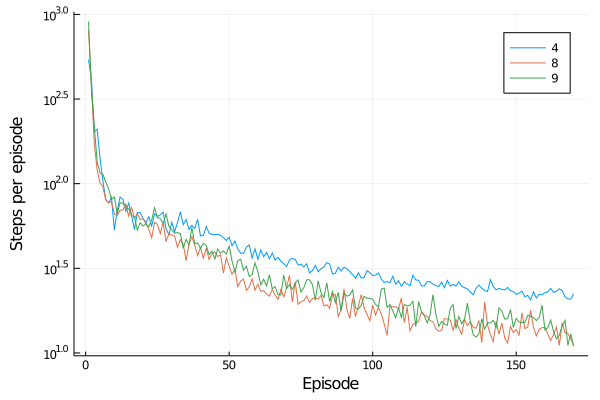

In [8]:
plot(
    steps_per_actions,
    label=experiment_actions,
    yaxis=:log,
    xlab="Episode",
    ylab="Steps per episode"
)

The above plot shows the steps needed until the terminal state for each successive episode,averaged over 50 runs. The plot is in log-scale since the differences would not be as appearant otherwise.

As can be seen, the agent with King's moves performs much better than without and reaches the optimal performance of the original agent after less than 100 episodes. Adding an action to do nothing, however, does not affect the outcome.

Below a sample resulting trajectory is given:

In [18]:
"""
Draws a possible trajectory using a given action value table using an epsilon-greedy policy
"""
function draw_trajectory(g::Gridworld, values; epsilon=epsilon, stochastic=false)
    grid = zeros(g.rows, length(g.wind))
    reset_state(g)
    step = 0
    episode_end = false
    state = g.agent
    action = rand() < epsilon ? rand(actions) : argmax(values[state, :])
    while !episode_end
        step += 1
        reward, episode_end = act(g, action; stochastic=stochastic)
        state_new = g.agent
        action_new = rand() < epsilon ? rand(actions) : argmax(values[state_new, :])
        grid[state_new] = step
        state = state_new
        action = action_new
    end
    grid
end

draw_trajectory(gridworld, values)

7×10 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  7.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  6.0  0.0  0.0  0.0
 0.0  0.0  2.0  0.0  4.0  5.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0

## Exercise 6.10

In [29]:
values, steps = sarsa(gridworld, actions, episodes; stochastic=true);

In [11]:
steps_per_actions = []
for last_action in experiment_actions
    steps_per_episode = run_experiment(last_action)
    avg_steps = transpose(mean(steps_per_episode, dims=1))
    push!(steps_per_actions, avg_steps)
end

for last_action in experiment_actions
    steps_per_episode = run_experiment(last_action; stochastic=true)
    avg_steps = transpose(mean(steps_per_episode, dims=1))
    push!(steps_per_actions, avg_steps)
end

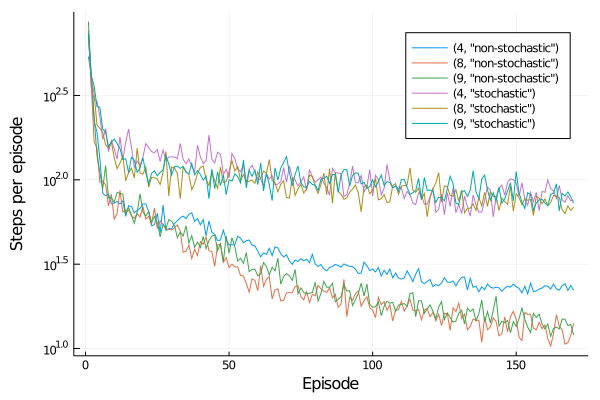

In [12]:
labels = reshape(collect(product(experiment_actions, ["non-stochastic" "stochastic"])), (1,6))
plot(
    steps_per_actions,
    label=labels,
    yaxis=:log,
    xlab="Episode",
    ylab="Steps per episode"
)

The above plot again shows the steps needed until the terminal state for each successive episode, this time for both stochastic and non-stochastic wind gridworlds. It can be seen that the agent performs worse in the stochastic wind setting. It is still able to reach a good performance, but it takes drastically more episodes. Interestingly, the performance differences between original moves and King's moves are not as stark as in the non-stochastic setting. This is likely due to the fact that the agents did not converge yet. This same phenomenon can be seen in the initial 30 episodes of the non-stochastic settings, where all agents perform equally well. 

A sample trajectory can be seen below:

In [30]:
draw_trajectory(gridworld, values, stochastic=true)

7×10 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0   0.0   0.0  13.0  14.0  17.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0  15.0  16.0   0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  25.0
 0.0  0.0  0.0  0.0  5.0  11.0  12.0  29.0   0.0   0.0
 1.0  0.0  3.0  4.0  0.0   6.0   0.0   0.0  23.0  26.0
 0.0  2.0  0.0  0.0  0.0   8.0  10.0   0.0  27.0  21.0
 0.0  0.0  0.0  0.0  0.0   9.0   0.0  28.0   0.0  22.0

In [36]:
values, steps = sarsa(gridworld, actions, 1000; stochastic=true)
draw_trajectory(gridworld, values, stochastic=true)

7×10 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  8.0  9.0  10.0  0.0  0.0
 0.0  2.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  7.0  6.0  0.0   0.0  0.0  0.0
 0.0  0.0  3.0  4.0  5.0  0.0  0.0   0.0  0.0  0.0